## Creating synonym and not synonym dataset using wordnet

First let's create a dataset of pairs of words that are synonyms or not synonyms using wordnet's synsets.

*Note*: "not synonyms" is not equivalent of antonyms, it simply means selecting any word `w2` in `(w1, w2)` pair in which the word `w2` is not in the set of synonyms to `w1`, i.e. we are simply performing **negative sampling**. 

In [16]:
import random
from itertools import combinations, chain
import gzip

import networkx as nx 
from nltk.corpus import wordnet as wn
import matplotlib.pyplot as plt

from tqdm import tqdm
import editdistance
import pandas as pd

random.seed(0)

In [2]:
def get_synsets(part_of_speeches=None, verbose=True):
    """
    returns a dictionary where key is a particular part of speech
    and value is the list of all synsets in that POS, if default
    `part_of_speeches` is `None`, will use, verb, noun and adjectives.
    """
    if part_of_speeches is None:
        part_of_speeches={'verb': 'v', 'noun': 'n', 'adjective': 'a'}
        
    pos_synsets = dict()
    for name, pos in part_of_speeches.items():
        pos_synsets[name] = list(wn.all_synsets(pos))
        if verbose:
            print(f"found {len(pos_synsets[name])} synsets for {name}")
            
    return pos_synsets

In [3]:
pos_synsets = get_synsets()

found 13767 synsets for verb
found 82115 synsets for noun
found 18156 synsets for adjective


In [4]:
def _is_single_word(word):
    """
    helper function for removing lemma names that contains multiple words, 
    separated by `-` or `_` 
    """
    return (('_' not in word) and ('-' not in word))

def get_syngraph_wordset(pos_synsets, verbose=True):
    """
    Uses the `pos_synsets` dictionary to create a dictionary
    of same keys where values are the synonym graphs using `.lemma_names()`
    of each synsets, see: http://www.nltk.org/howto/wordnet.html
    """
    syn_graphs = dict()
    for pos, synsets in pos_synsets.items():
        syn_graphs[pos] = nx.Graph()
        
        for synset in synsets:
            lemma_names = [x for x in synset.lemma_names() if _is_single_word(x)]
            
            if len(lemma_names) > 1:
                syn_graphs[pos].add_edges_from(combinations(lemma_names, 2))
                        
        if verbose:
            msg_fmt = "Found {} synonym pairs and {} unique words in {}"
            print(msg_fmt.format(len(syn_graphs[pos].edges), 
                                 len(syn_graphs[pos].nodes), 
                                 pos))
    
    return syn_graphs
    

In [5]:
syn_graphs = get_syngraph_wordset(pos_synsets)

Found 14046 synonym pairs and 6324 unique words in verb
Found 37696 synonym pairs and 29272 unique words in noun
Found 17737 synonym pairs and 12057 unique words in adjective


In [6]:
print(list(syn_graphs['verb'].neighbors('change')))

['alter', 'vary', 'modify', 'exchange', 'commute', 'convert', 'switch', 'shift', 'deepen', 'transfer', 'interchange']


In [7]:
print(list(syn_graphs['noun'].neighbors('ocean')))

['sea']


In [8]:
print(list(syn_graphs['adjective'].neighbors('large')))

['big', 'enceinte', 'expectant', 'gravid', 'great', 'heavy', 'prominent', 'magnanimous', 'bombastic', 'declamatory', 'orotund', 'tumid', 'turgid']


In [9]:
def get_subgraph(graph, subset=['change', 'buy']):
    """
    Create a subgraph of graph with only nodes and nieghbors
    given in `subset`.
    """
    nodes = []
    
    for node in subset:
        nodes.append(node)
        nodes.extend(graph.neighbors(node))
    
    subgraph = graph.subgraph(nodes)
    
    return subgraph

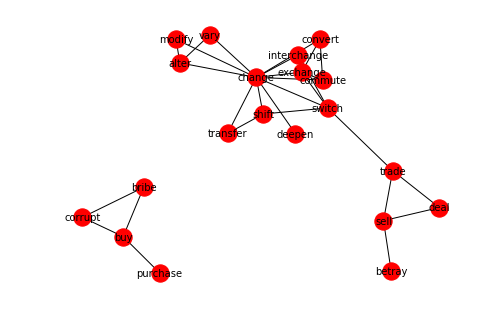

In [10]:
subgraph = get_subgraph(syn_graphs['verb'], subset=['sell', 'buy', 'change'])
pos=nx.spring_layout(subgraph, iterations=150, k=1.5)
nx.draw(subgraph, pos=pos)
nx.draw_networkx_labels(subgraph, pos=pos, font_size=10)
plt.show()
# plt.savefig('graph.png')

![alttag](./img/graph.png)

In [11]:
def create_dataset(syn_graphs, train_test_component_ratio=0.5, 
                   negative_sampling_count=1):
    weights = {'verb': 1.15,
               'adjective': 1.0,
               'noun': 1.0}

    for pos, graph in syn_graphs.items():
        edges = [(x, y) for (x, y) in graph.edges]
        all_words_len = len(graph.nodes)
        train_len = int(all_words_len*train_test_component_ratio)
        train_words = set()
        test_words = set()
        train_edges = list()
        test_edges = list()
        for (x, y) in edges:
            if len(train_words) < train_len*weights[pos]:
                train_edges.append((x, y))
                train_words.update({x, y})
            else:
                test_edges.append((x, y))
                test_words.update({x, y})
                
        print("{}, train {}, test {}, intersec {}, train {}, test {}".format(
                pos, len(train_words), len(test_words),
                len(train_words.intersection(test_words)),
                len(train_words.difference(test_words)), 
                len(test_words.difference(train_words)))) 
        
        intersection = train_words.intersection(test_words)
        train_sampling = train_words.difference(intersection)
        test_sampling = test_words.difference(intersection)
        for (data, split) in zip([train_edges, test_edges], ['train', 'test']):
            for (w1, w2) in data:
                if editdistance.eval(w1, w2) < 2:
                    continue
                if (w1 in intersection) or (w2 in intersection):
                    continue
                pos_words =[w1]
                pos_words.extend(list(graph.neighbors(w1)))
                pos_words = set(pos_words)
                if split == 'train':
                    neg_words = list(train_sampling.difference(pos_words))
                else:
                    neg_words = list(test_sampling.difference(pos_words))
                neg_sampling = random.choices(neg_words, k=negative_sampling_count)
                yield {'word1': w1, 'word2': w2, 'synonym': 1, 'pos': pos, 'split': split}
                for w3 in neg_sampling:
                    yield {'word1': w1, 'word2': w3, 'synonym': 0, 'pos': pos, 'split': split}


In [12]:
df = pd.DataFrame.from_dict(list(create_dataset(syn_graphs, negative_sampling_count=10)))

verb, train 3637, test 4186, intersec 1499, train 2138, test 2687
noun, train 14636, test 17377, intersec 2741, train 11895, test 14636
adjective, train 6028, test 7553, intersec 1524, train 4504, test 6029


In [13]:
df.groupby(['pos', 'split', 'synonym']).size()

pos        split  synonym
adjective  test   0           50220
                  1            5022
           train  0           63840
                  1            6384
noun       test   0          113500
                  1           11350
           train  0          133650
                  1           13365
verb       test   0           26940
                  1            2694
           train  0           31790
                  1            3179
dtype: int64

In [14]:
df.loc[df.word1=='change'].head(20)

,pos,split,synonym,word1,word2
16995,verb,train,1,change,vary
16996,verb,train,0,change,brood
16997,verb,train,0,change,capitalize
16998,verb,train,0,change,beget
16999,verb,train,0,change,mercerize
17000,verb,train,0,change,disintegrate
17001,verb,train,0,change,shoetree
17002,verb,train,0,change,spotlight
17003,verb,train,0,change,domesticize
17004,verb,train,0,change,decree


In [20]:
df.to_csv('../datasets/synonym_dataset.csv.gz', compression='gzip')